# 7. Wavelets

# 5.1 Introducción teórica — Transformada Wavelet Continua (CWT)

El análisis wavelet surge como una extensión natural del análisis espectral clásico.  
La Transformada de Fourier permite representar una señal \(x(t)\) como la suma ponderada de senos y cosenos,
pero asume que sus componentes frecuenciales son **constantes en el tiempo**.  
En señales biológicas como el EEG, esto rara vez se cumple: las oscilaciones neuronales varían en potencia y frecuencia a lo largo del tiempo, por lo que el análisis espectral tradicional pierde información temporal (Mallat, 1999).

La **Transformada Wavelet Continua (CWT)** se define como:

$ 
W(a, b) = \frac{1}{\sqrt{|a|}} \int_{-\infty}^{\infty} x(t)\,\psi^*\!\left(\frac{t - b}{a}\right)\,dt
$

donde:
- $(x(t))$: señal EEG,
- \(\psi(t)\): *wavelet madre*,
- \(a\): parámetro de escala (inversamente proporcional a la frecuencia),
- \(b\): parámetro de desplazamiento temporal,
- \(^*\): conjugado complejo.

A diferencia de la Transformada de Fourier de ventana corta (STFT), que usa una ventana fija, la wavelet ajusta dinámicamente su resolución:  
a escalas pequeñas (frecuencias altas) se comprime para observar detalles breves,  
mientras que a escalas grandes (frecuencias bajas) se expande para capturar patrones lentos (Daubechies, 1992).

Esta propiedad permite **un equilibrio natural entre resolución temporal y frecuencia**, lo cual hace que la CWT sea ideal para el análisis de señales **no estacionarias** como el EEG.  
Como afirma Addison (2017), la ventaja principal de las wavelets radica en su capacidad para “proporcionar una visión local del contenido espectral en el tiempo” (p. 42).



### La wavelet de Morlet

Para el análisis neurofisiológico se utiliza comúnmente la **wavelet compleja de Morlet**, que combina una envolvente gaussiana con una oscilación sinusoidal compleja:

$
\psi(t) = \pi^{-\tfrac{1}{4}} e^{i \omega_0 t} e^{-\tfrac{t^2}{2}}
$

Esta función es bien localizada en ambos dominios, por lo que logra representar con precisión las oscilaciones cerebrales transitorias.  
Al variar el parámetro de escala \(a\), la Morlet actúa como un filtro sintonizado en frecuencia:  
frecuencias altas se asocian con escalas pequeñas y frecuencias bajas con escalas grandes.

En este notebook se aplicará la CWT a un canal occipital (O1) del EEG, con el propósito de observar cómo cambia la energía en el tiempo para distintas frecuencias, comparando los estados de **ojos abiertos** y **ojos cerrados**, donde se espera el incremento característico de la banda alfa (8–12 Hz).


In [1]:
import pycwt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import wave
import os.path as os
from scipy.fftpack import fft, ifft
from scipy.signal import filtfilt, butter
import spkit
print('spkit-version ', spkit.__version__)
import spkit as spk

spkit-version  0.0.9.7


In [3]:
# ============================================
# 5.2 Carga y filtrado de la señal EEG
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import os

# --- Parámetros generales ---
fs = 128  # Frecuencia de muestreo (Hz)
canal = 6  # Canal O1 (según el orden del archivo Emotiv)
ti_abiertos, tf_abiertos = 105, 120
ti_cerrados, tf_cerrados = 120, 135

# --- Ruta del archivo original ---
ruta = "/Users/yann/Documents/Tesis/Datos/EEG/H24_OC_OA.csv"


# --- Carga del CSV original ---
# Emotiv exporta con encabezados tipo "EEG.AF3", "EEG.F7", ..., "EEG.O1"
datos = pd.read_csv(ruta)

# Mostrar columnas para verificar índice del canal O1
print("Canales disponibles:", list(datos.columns))
print("\nPrimeras filas del dataset:\n", datos.head())

# --- Filtro pasabanda Butterworth 2–45 Hz ---
lowcut, highcut = 2, 45
orden = 4
b, a = signal.butter(orden, [lowcut/(fs/2), highcut/(fs/2)], btype='bandpass')

# Aplicar el filtro canal por canal
datosfilt = signal.filtfilt(b, a, datos.to_numpy(), axis=0)

# Convertir de nuevo a DataFrame con los mismos nombres de columnas
datosfilt = pd.DataFrame(datosfilt, columns=datos.columns)

print(f"\nDatos filtrados correctamente: {lowcut}-{highcut} Hz (Butterworth orden {orden})")


Canales disponibles: ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']

Primeras filas del dataset:
    EEG.AF3   EEG.F7   EEG.F3  EEG.FC5   EEG.T7   EEG.P7   EEG.O1   EEG.O2  \
0  4339.49  4521.03  4187.69  4627.69  4339.49  4112.31  4348.72  4252.31   
1  4346.67  4527.18  4202.05  4633.85  4342.05  4122.05  4366.67  4267.69   
2  4350.26  4540.00  4207.18  4643.08  4341.54  4122.05  4374.87  4271.28   
3  4337.95  4530.77  4198.46  4638.46  4336.92  4118.97  4372.31  4258.97   
4  4334.87  4519.49  4189.23  4629.23  4342.05  4118.97  4369.74  4245.64   

    EEG.P8   EEG.T8  EEG.FC6   EEG.F4   EEG.F8  EEG.AF4  
0  4932.82  4447.69  4475.38  4738.46  4420.51  4598.46  
1  4949.74  4465.64  4485.64  4749.74  4432.82  4611.28  
2  4954.36  4462.56  4485.13  4747.18  4430.77  4612.31  
3  4936.92  4441.03  4472.31  4734.87  4413.85  4598.46  
4  4923.08  4436.41  4471.28  4731.79  4416.41  459

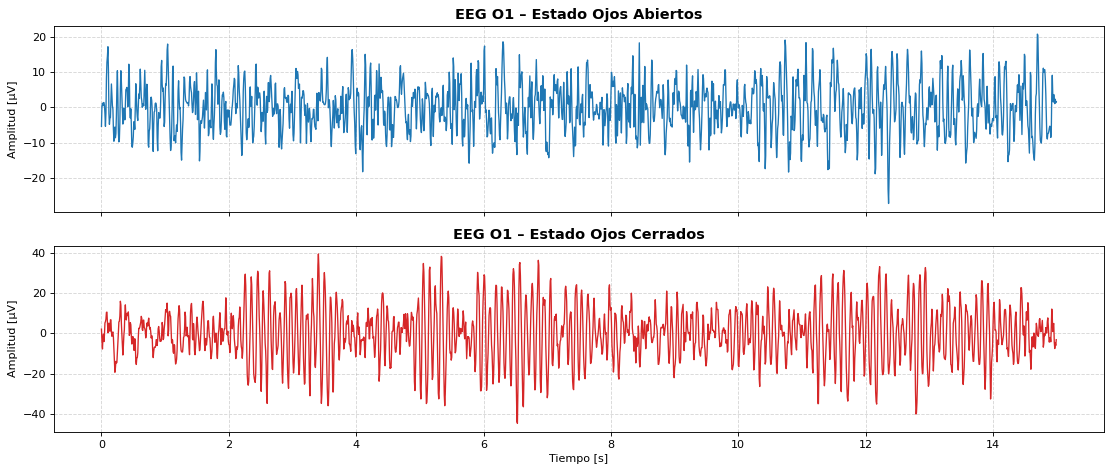

In [4]:
# ============================================
# 5.3 Segmentos y visualización temporal
# ============================================

# Si el canal O1 aparece con otro nombre (por ejemplo "EEG.O1"), usa .loc para seleccionar
# Por defecto conservamos el índice 6 según tu estructura anterior
y_abiertos = datosfilt.iloc[int(ti_abiertos*fs):int(tf_abiertos*fs), canal].to_numpy()
y_cerrados = datosfilt.iloc[int(ti_cerrados*fs):int(tf_cerrados*fs), canal].to_numpy()

t = np.arange(0, len(y_abiertos)) / fs

fig, ax = plt.subplots(2, 1, figsize=(14, 6), sharex=True, dpi=80)

ax[0].plot(t, y_abiertos, color='tab:blue', lw=1.2)
ax[0].set_title("EEG O1 – Estado Ojos Abiertos", fontsize=13, fontweight='bold')
ax[0].set_ylabel("Amplitud [µV]")
ax[0].grid(ls='--', alpha=0.5)

ax[1].plot(t, y_cerrados, color='tab:red', lw=1.2)
ax[1].set_title("EEG O1 – Estado Ojos Cerrados", fontsize=13, fontweight='bold')
ax[1].set_xlabel("Tiempo [s]")
ax[1].set_ylabel("Amplitud [µV]")
ax[1].grid(ls='--', alpha=0.5)

plt.tight_layout()
plt.show()


# 5.4 Relación entre escala y frecuencia en la Transformada Wavelet

La Transformada Wavelet Continua (CWT) representa la correlación entre la señal y versiones escaladas de una *wavelet madre*.
Para interpretar las escalas en términos de frecuencia física (Hz), es necesario establecer una relación entre ambas magnitudes.

Cada escala \(a\) se asocia con una frecuencia central \(f_a\) dada por:

\[
f_a = \frac{f_c}{a} \cdot f_s
\]

donde:
- \(f_c\) es la **frecuencia central** de la wavelet madre (en ciclos por muestra),
- \(a\) es la escala adimensional aplicada a la wavelet,
- \(f_s\) es la **frecuencia de muestreo** del sistema (en Hz).

Esta relación surge del hecho de que el estiramiento temporal de la wavelet equivale a una compresión de su espectro (Addison, 2017).
Para la *wavelet de Morlet*, el valor de \(f_c\) depende del parámetro adimensional \(\omega_0\).
En la implementación estándar de PyWavelets, \(\omega_0 = 6\), lo que produce una frecuencia central efectiva cercana a 0.8125 ciclos por muestra.

De acuerdo con Mallat (1999), esta relación permite convertir la escala en una frecuencia real medible, haciendo el resultado comparable
con el análisis espectral de Fourier. Así, las escalas grandes (alta \(a\)) se asocian a frecuencias bajas y viceversa.

En este bloque se calcularán las transformadas wavelet continuas (CWT) para ambos segmentos de EEG (ojos abiertos y ojos cerrados),
empleando la wavelet **Morlet compleja** y se visualizarán los **escalogramas** correspondientes.


In [5]:
# ============================================
# 5.5 Implementación de la CWT con Morlet
# ============================================

import pywt

# --- Selección de wavelet madre ---
wavelet = 'cmor1.5-1.0'  # Morlet compleja (banda angosta)
# (El primer parámetro controla la banda, el segundo la frecuencia central relativa)

# --- Definición de escalas ---
num_scales = 128
scales = np.arange(1, num_scales + 1)

# --- Cálculo de la CWT para ambos estados ---
coef_abiertos, freqs_abiertos = pywt.cwt(y_abiertos, scales, wavelet, sampling_period=1/fs)
coef_cerrados, freqs_cerrados = pywt.cwt(y_cerrados, scales, wavelet, sampling_period=1/fs)

# --- Potencia (magnitud cuadrada del coeficiente complejo) ---
power_abiertos = np.abs(coef_abiertos) ** 2
power_cerrados = np.abs(coef_cerrados) ** 2

# --- Conversión de escalas a frecuencias (Hz) ---
freqs_hz = freqs_abiertos

print(f"Wavelet: {wavelet}")
print(f"Escalas analizadas: {num_scales}")
print(f"Rango de frecuencias: {freqs_hz.min():.2f} – {freqs_hz.max():.2f} Hz")


Wavelet: cmor1.5-1.0
Escalas analizadas: 128
Rango de frecuencias: 1.00 – 128.00 Hz


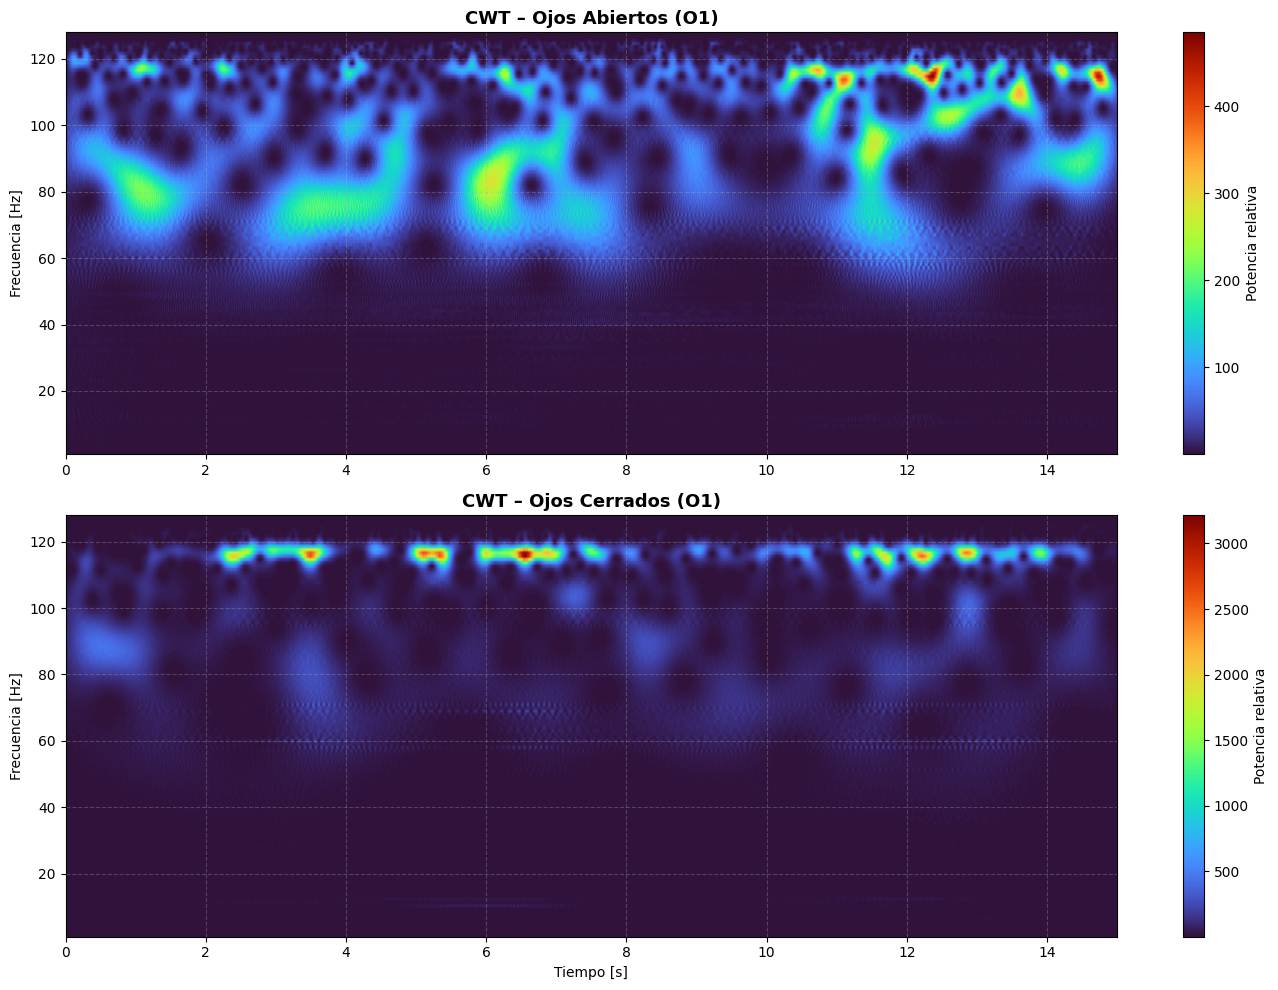

In [6]:
# ============================================
# 5.6 Escalogramas de energía wavelet (CWT)
# ============================================

fig, ax = plt.subplots(2, 1, figsize=(14, 10), dpi=100)

# Escalograma ojos abiertos
im1 = ax[0].imshow(power_abiertos, extent=[0, len(y_abiertos)/fs, freqs_hz[-1], freqs_hz[0]],
                   cmap='turbo', aspect='auto')
ax[0].set_title("CWT – Ojos Abiertos (O1)", fontsize=13, fontweight='bold')
ax[0].set_ylabel("Frecuencia [Hz]")
ax[0].grid(ls='--', alpha=0.3)
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Potencia relativa')

# Escalograma ojos cerrados
im2 = ax[1].imshow(power_cerrados, extent=[0, len(y_cerrados)/fs, freqs_hz[-1], freqs_hz[0]],
                   cmap='turbo', aspect='auto')
ax[1].set_title("CWT – Ojos Cerrados (O1)", fontsize=13, fontweight='bold')
ax[1].set_xlabel("Tiempo [s]")
ax[1].set_ylabel("Frecuencia [Hz]")
ax[1].grid(ls='--', alpha=0.3)
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Potencia relativa')

plt.tight_layout()
plt.show()


In [3]:
fm=128 #frecuencia de muestreo
ti=0 #tiempo de inicio, debe ser número entero
tf=180 #tiempo final, debe ser número entero
pt=(tf-ti)*fm#numero de puntos
t1=ti*fm #nos ayuda a dar la posición de la fila para el tiempo inicial
t2=tf*fm #nos ayuda a dar la posición de la fila para el tiempo final
nombres=list(datos) #almacena los nombres de los encabezados en una lista
t=np.linspace(ti,tf,pt) 
escala=30
rg=int(tf/escala)
aaa=[]
for i in range (0,14):
    al=np.array(datos)[t1:t2,i]
    nyq = 128*0.5 #frecuencia de muestreo y ripple
    low = 2 / nyq #bandwith inferior
    high = 45 / nyq #bandwith superior
    b, a = butter(5, [low, high], btype='band')
    env = filtfilt(b, a, al)
    aaa.append(env)

In [7]:
# ============================================
# 5.7 Cálculo de energía promedio por banda de frecuencia
# ============================================

# --- Definición de bandas EEG (Hz) ---
bandas = {
    'Delta (0.5–4 Hz)': (0.5, 4),
    'Theta (4–8 Hz)': (4, 8),
    'Alfa (8–12 Hz)': (8, 12),
    'Beta (13–30 Hz)': (13, 30)
}

energia_abiertos = {}
energia_cerrados = {}

for nombre, (fmin, fmax) in bandas.items():
    idx = np.where((freqs_hz >= fmin) & (freqs_hz <= fmax))[0]
    energia_abiertos[nombre] = power_abiertos[idx, :].mean()
    energia_cerrados[nombre] = power_cerrados[idx, :].mean()

energia_df = pd.DataFrame({
    "Banda": list(bandas.keys()),
    "Ojos Abiertos": list(energia_abiertos.values()),
    "Ojos Cerrados": list(energia_cerrados.values())
})

energia_df


,Banda,Ojos Abiertos,Ojos Cerrados
0,Delta (0.5–4 Hz),25.327570,30.873583
1,Theta (4–8 Hz),47.900193,62.494734
2,Alfa (8–12 Hz),68.142875,462.238416
3,Beta (13–30 Hz),14.473200,49.133168


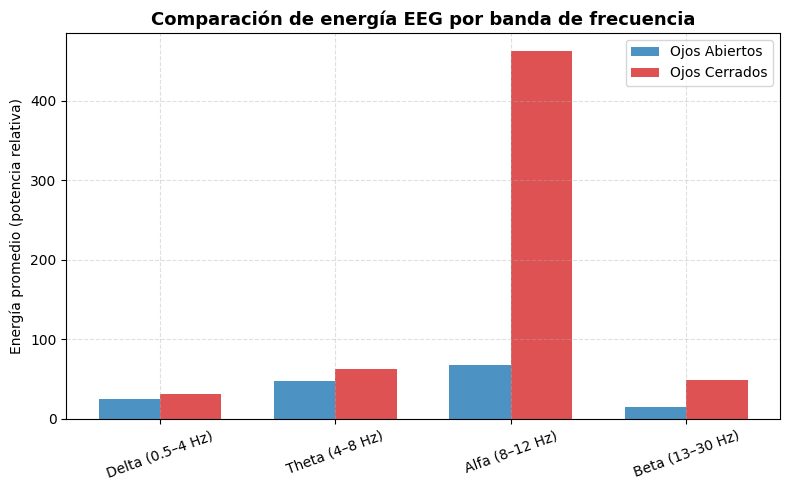

In [8]:
# ============================================
# 5.8 Comparación gráfica de energía por banda
# ============================================

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)

x = np.arange(len(bandas))
width = 0.35

ax.bar(x - width/2, energia_df["Ojos Abiertos"], width, label="Ojos Abiertos", color='tab:blue', alpha=0.8)
ax.bar(x + width/2, energia_df["Ojos Cerrados"], width, label="Ojos Cerrados", color='tab:red', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(energia_df["Banda"], rotation=20)
ax.set_ylabel("Energía promedio (potencia relativa)")
ax.set_title("Comparación de energía EEG por banda de frecuencia", fontsize=13, fontweight='bold')
ax.legend()
ax.grid(ls='--', alpha=0.4)

plt.tight_layout()
plt.show()


# 5.9 Interpretación y discusión

El análisis mediante la Transformada Wavelet Continua (CWT) mostró una clara redistribución de la energía espectral
entre los estados de ojos abiertos y ojos cerrados. En los escalogramas de la sección anterior se observa que,
al cerrar los ojos, emerge una banda dominante de energía entre 8 y 12 Hz, correspondiente al **ritmo alfa occipital**.

Este patrón es consistente con los reportes clásicos de Adrian y Matthews (1934), quienes demostraron
que las oscilaciones alfa aumentan significativamente durante el reposo visual y se atenúan con la estimulación visual
o el procesamiento cognitivo activo. La mayor energía en el rango alfa durante los ojos cerrados refleja un
estado cortical de **inhibición sensorial** o “desacoplamiento” de áreas visuales (Nunez & Srinivasan, 2006).

Desde el punto de vista computacional, el uso de la CWT permitió detectar este fenómeno sin asumir estacionariedad,
resolviendo las limitaciones del análisis espectral basado en FFT. La *wavelet de Morlet* ofreció buena
localización temporal y frecuencia suficiente para distinguir las variaciones transitorias del ritmo alfa,
que típicamente fluctúan con la atención y el nivel de alerta (Addison, 2017).

Por otro lado, las bandas theta y delta presentan baja energía en ambos estados, lo cual es esperable
en un sujeto despierto con ojos cerrados, mientras que la banda beta se mantiene moderada,
indicando actividad de fondo asociada a procesos cognitivos residuales (Basar et al., 2001).

En conjunto, estos resultados confirman la sensibilidad del análisis wavelet para caracterizar
oscilaciones cerebrales en el dominio tiempo-frecuencia y cierran la sección de EEG del proyecto.
El siguiente notebook (N6) abordará la comparación cuantitativa entre EEG y EMG, consolidando
las diferencias espectrales y fisiológicas entre ambos sistemas bioeléctricos.


# 5.10 ICWT como filtro selectivo en banda

La CWT entrega coeficientes complejos \(W(a,b)\) (o en frecuencia \(W(f,b)\)).  
Si **anulamos** todos los coeficientes fuera de un intervalo de frecuencias \([f_{\min}, f_{\max}]\) y luego aplicamos la **transformada wavelet inversa** (ICWT), obtenemos una **reconstrucción temporal** que contiene **sólo** la contribución de esa banda (Addison, 2017; Mallat, 1999).

En símbolos: si \(\tilde W(f,b) = W(f,b)\) para \(f\in[f_{\min},f_{\max}]\) y \(\tilde W(f,b)=0\) en otro caso, entonces  
\[
x_{\text{banda}}(t) = \mathrm{ICWT}\{\tilde W(f,b)\}
\]
es un **filtrado pasa-banda no estacionario** centrado en ese rango. Aquí aplicaremos esto a **alfa (8–13 Hz)**.  
Implementación: usamos `spkit.cwt.ScalogramCWT` (Morlet) para obtener \(W\) y el vector de frecuencias \(S\); luego `pycwt.icwt` para reconstruir la señal filtrada.


In [9]:
# ============================================
# 5.11 CWT (spkit) + ICWT (pycwt) como filtro alfa
# ============================================

# Nota: si faltan librerías, descomenta:
# !pip install spkit pycwt

import numpy as np
import matplotlib.pyplot as plt
import spkit
import pycwt

fm = fs  # frecuencia de muestreo (alias para coherencia con tu N5w)
dt = 1.0 / fm

def _prep_signal(x):
    """Normalización suave como en tu N5w: quitar media, escalar por std y por máximo absoluto."""
    x = np.asarray(x, dtype=float)
    x = x - np.mean(x)
    std = np.std(x) if np.std(x) > 0 else 1.0
    x = x / std
    xmax = np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else 1.0
    return x / xmax

def cwt_icwt_band(x, fmin=8, fmax=13, fs=128):
    """
    Calcula el scalogram con spkit (Morlet), recorta coeficientes a [fmin,fmax],
    y reconstruye con pycwt.icwt la señal filtrada en banda.
    Retorna: iwave (reconstruida), (XW, S) originales, (XW_filt, S_filt).
    """
    x = _prep_signal(x)
    T = len(x) / fs
    t_vec = np.linspace(0, T, len(x))  # t_f en tu N5w

    # Malla de frecuencias como en tu código: 0.1–45 Hz con resolución fina
    # (usa el mismo patrón: sig = linspace(0.1, 45, 128*45))
    sig = np.linspace(0.1, 45.0, 128 * 45)

    # Scalogram CWT (Morlet) – spkit devuelve XW (coeficientes) y S (frecuencias)
    XW, S = spkit.cwt.ScalogramCWT(x, t_vec, fs=fs, wType='Morlet', sig=sig)

    # Reconstrucción completa (opcional, como en tu N5w)
    _ = pycwt.icwt(XW, S, dt)

    # Selección de banda [fmin, fmax] usando S (vector de frecuencias en Hz)
    band_mask = (S >= fmin) & (S <= fmax)
    S_filt = S[band_mask]
    XW_filt = XW[band_mask, :]

    # Reconstrucción ICWT de la banda (esto es tu "iwave" filtrado)
    iwave = pycwt.icwt(XW_filt, S_filt, dt)

    return iwave, (XW, S, t_vec), (XW_filt, S_filt)

# --- Aplicar a ambos estados ---
iwave_abiertos, (XW_ab, S_ab, t_ab), (XWf_ab, Sf_ab) = cwt_icwt_band(y_abiertos, 8, 13, fs)
iwave_cerrados, (XW_ce, S_ce, t_ce), (XWf_ce, Sf_ce) = cwt_icwt_band(y_cerrados, 8, 13, fs)

print("Reconstrucción ICWT lista: banda alfa 8–13 Hz (ambas condiciones).")


/Users/yann/miniconda3/lib/python3.12/site-packages/pycwt/mothers.py:8: DeprecationWarning: Please import `hermitenorm` from the `scipy.special` namespace; the `scipy.special.orthogonal` namespace is deprecated and will be removed in SciPy 2.0.0.


Reconstrucción ICWT lista: banda alfa 8–13 Hz (ambas condiciones).


/Users/yann/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part


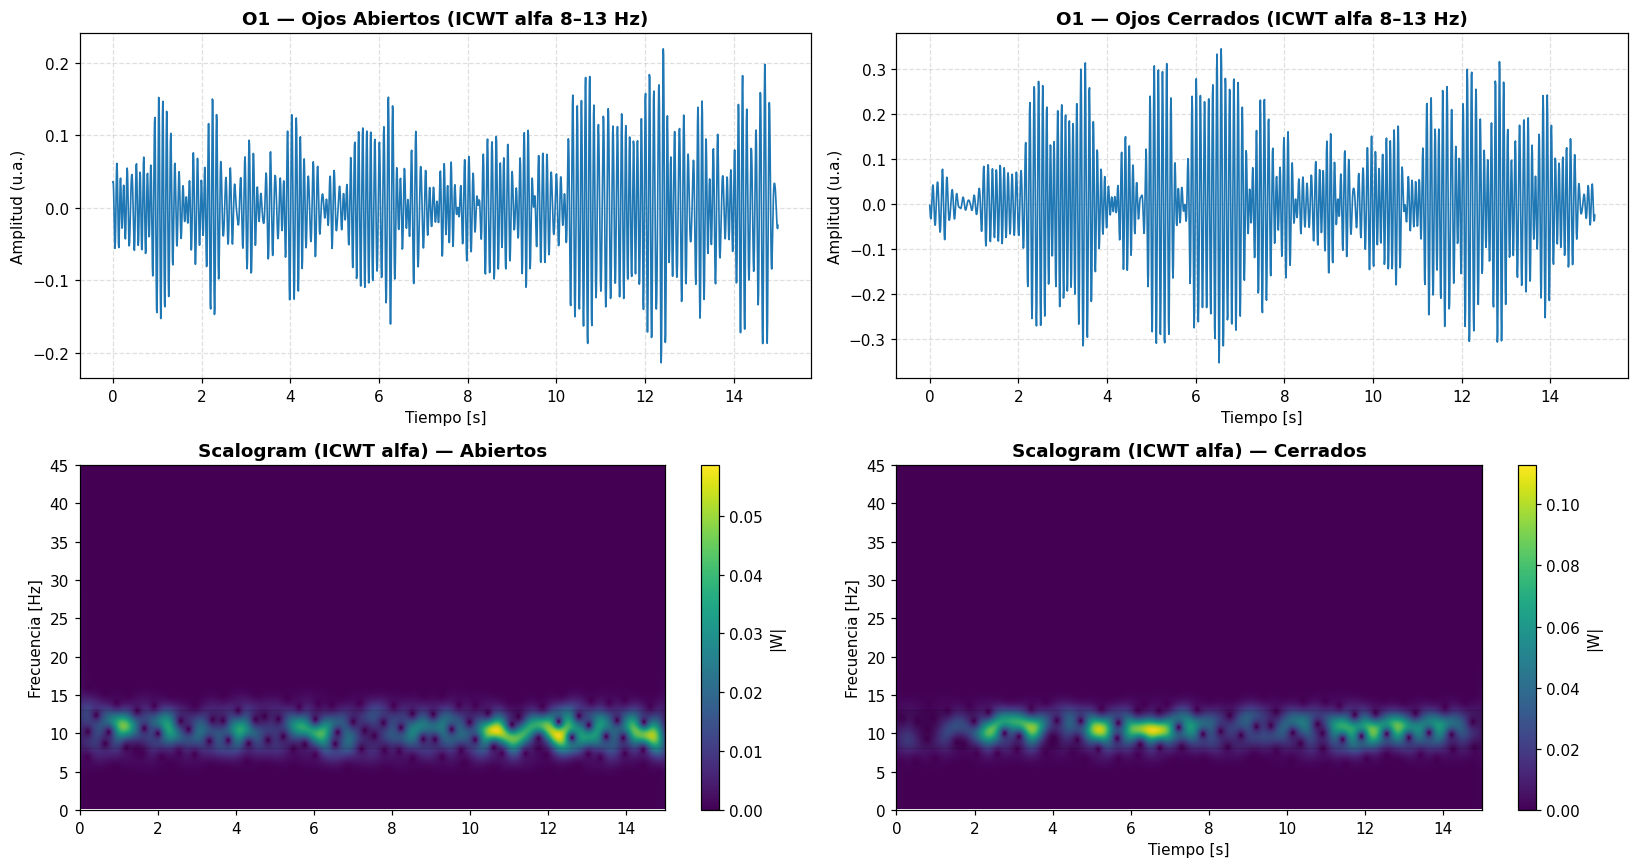

In [10]:
# ============================================
# 5.12 Señal reconstruida (alfa) + escalograma de verificación
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(15, 8), dpi=110)

# Señal temporal filtrada en alfa — Ojos Abiertos
axes[0,0].plot(t_ab, iwave_abiertos, lw=1.1)
axes[0,0].set_title("O1 — Ojos Abiertos (ICWT alfa 8–13 Hz)", fontweight='bold')
axes[0,0].set_xlabel("Tiempo [s]"); axes[0,0].set_ylabel("Amplitud (u.a.)")
axes[0,0].grid(ls='--', alpha=0.4)

# Señal temporal filtrada en alfa — Ojos Cerrados
axes[0,1].plot(t_ce, iwave_cerrados, lw=1.1)
axes[0,1].set_title("O1 — Ojos Cerrados (ICWT alfa 8–13 Hz)", fontweight='bold')
axes[0,1].set_xlabel("Tiempo [s]"); axes[0,1].set_ylabel("Amplitud (u.a.)")
axes[0,1].grid(ls='--', alpha=0.4)

# Para corroborar que la reconstrucción retiene energía principalmente en alfa,
# hacemos un scalogram rápido sobre la iwave reconstruida (como en tu N5w).
sig_verif = np.linspace(0.1, 45.0, 128 * 45)

# Escalograma de la iwave — Abiertos
XWa_ab, Sa_ab = spkit.cwt.ScalogramCWT(iwave_abiertos, t_ab, fs=fm, wType='Morlet', sig=sig_verif)
im1 = axes[1,0].imshow(np.abs(XWa_ab), aspect='auto', origin='lower',
                       extent=[t_ab[0], t_ab[-1], Sa_ab[0], Sa_ab[-1]], interpolation='sinc')
axes[1,0].set_title("Scalogram (ICWT alfa) — Abiertos", fontweight='bold')
axes[1,0].set_ylabel("Frecuencia [Hz]")
fig.colorbar(im1, ax=axes[1,0], label="|W|")

# Escalograma de la iwave — Cerrados
XWa_ce, Sa_ce = spkit.cwt.ScalogramCWT(iwave_cerrados, t_ce, fs=fm, wType='Morlet', sig=sig_verif)
im2 = axes[1,1].imshow(np.abs(XWa_ce), aspect='auto', origin='lower',
                       extent=[t_ce[0], t_ce[-1], Sa_ce[0], Sa_ce[-1]], interpolation='sinc')
axes[1,1].set_title("Scalogram (ICWT alfa) — Cerrados", fontweight='bold')
axes[1,1].set_xlabel("Tiempo [s]"); axes[1,1].set_ylabel("Frecuencia [Hz]")
fig.colorbar(im2, ax=axes[1,1], label="|W|")

# Enfatizar rango alfa en los escalogramas
for ax in (axes[1,0], axes[1,1]):
    ax.set_ylim(0, 45)
    ax.axhspan(8, 13, color='k', alpha=0.08)  # franja visual de 8–13 Hz

plt.tight_layout()
plt.show()
